## Accessing ASTER data on Azure

This notebook demonstrates basic access to ASTER data on Azure, using the NASA CMR API to query for tiles, then accessing the tiles on Azure blob storage. Access is demonstrated for both the (temporary) HDF-formatted storage and the (eventually-permanent) COG-formatted storage. Because ASTER data are in preview, the user needs to provide storage credentials.

ASTER data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on ASTER data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using ASTER data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports

In [1]:
import re
import os
import datetime
import progressbar
import tempfile
import urllib
import shutil
import numpy as np
import matplotlib.pyplot as plt

import cv2
import rasterio
import gdal

# From fiona
import rasterio.features

from shapely.geometry import Point, Polygon
from cmr import GranuleQuery

### Constants

In [2]:
# Let's take a look at Seattle, which is at 47.6062° N, 122.3321° W
query_lon = -122.3321
query_lat = 47.6062
query_short_name = "AST_L1T"

query_start_date = datetime.datetime(2004, 1, 1, 0, 0, 0)
query_end_date = datetime.datetime(2004, 6, 1, 0, 0, 0)

# This should be a text file with a SAS token for the ASTER container on the first line, and
# for the ASTER COG container on the second line, both starting with "?sv".
aster_sas_file = r'c:\git\ai4edev\datamanagement\test_data\aster_ro_sas.txt' 

temp_dir = os.path.join(tempfile.gettempdir(),'aster')
os.makedirs(temp_dir,exist_ok=True)

### Azure storage location constants

In [4]:
assert os.path.isfile(aster_sas_file)
lines = []
with open(aster_sas_file,'r') as f:
    lines = f.readlines()
assert len(lines) >= 2
aster_hdf_sas = lines[0].strip()
aster_cog_sas = lines[1].strip()

aster_hdf_storage_account_name = 'astersa'
aster_hdf_container_name = 'aster'
aster_hdf_storage_account_url = \
  'https://' + aster_hdf_storage_account_name + '.blob.core.windows.net/'

aster_cog_storage_account_name = 'astersa'
aster_cog_container_name = 'aster-cogs'
aster_cog_storage_account_url = \
  'https://' + aster_cog_storage_account_name + '.blob.core.windows.net/'

# We don't actually use these in this notebook, but keeping these here since operations
# like listing all scenes in a folder would use this approach
if False:
    
    from azure.storage.blob import ContainerClient
    aster_hdf_container_client = ContainerClient(account_url=aster_hdf_storage_account_url, 
                                                 container_name=aster_hdf_container_name,
                                                 credential=aster_hdf_sas)
    
    aster_cog_container_client = ContainerClient(account_url=aster_cog_storage_account_url, 
                                                 container_name=aster_cog_container_name,
                                                 credential=aster_cog_sas)

### Search for granules

In [6]:
api = GranuleQuery()
granules = api.short_name(query_short_name).point(query_lon,query_lat).temporal(query_start_date, query_end_date).get()

print('Found {} matching grandules:'.format(len(granules)))
for granule in granules:
    print(granule['producer_granule_id'])

Found 8 matching grandules:
AST_L1T_00301152004192004_20150502205642_77732
AST_L1T_00301312004191949_20150503021343_41590
AST_L1T_00302162004191948_20150503071449_14017
AST_L1T_00302252004191342_20150503094209_103656
AST_L1T_00303012004055809_20150503111206_63967
AST_L1T_00303122004191330_20150503150451_61488
AST_L1T_00303192004191924_20150503172102_71396
AST_L1T_00304182004055733_20150504025056_115737


### Grab the first matching granule (arbitrary)

In [7]:
granule = granules[0]
print(granule['producer_granule_id'])

AST_L1T_00301152004192004_20150502205642_77732


### Map this to our Azure blob paths

In [9]:
# For the product:
#
# AST_L1T_00301152004192004_20150502205642_77732
#    
# Our path is:
#    
# https://astersa.blob.core.windows.net/aster/images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf
#
# images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf
#

granule_id = granule['producer_granule_id']
assert granule_id[0:11] == 'AST_L1T_003'

# E.g. 01152004
granule_date_string = granule_id[11:19]

granule_month = granule_date_string[0:2]
granule_day = granule_date_string[2:4]
granule_year = granule_date_string[4:8]

azure_hdf_path = '/'.join(['images','L1T',granule_year,granule_month,granule_day,granule_id + '.hdf'])
azure_cog_folder = azure_hdf_path.replace('.hdf','/').replace('AST_L1T_','')
azure_cog_paths = [azure_cog_folder + fn for fn in ['SWIR-cog.tif','TIR-cog.tif','VNIR-cog.tif']]
                                                    
print('Azure HDF path:\n{}'.format(azure_hdf_path))
print('\nAzure COG paths:')
for p in azure_cog_paths:
    print(p)

Azure HDF path:
images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf

Azure COG paths:
images/L1T/2004/01/15/00301152004192004_20150502205642_77732/SWIR-cog.tif
images/L1T/2004/01/15/00301152004192004_20150502205642_77732/TIR-cog.tif
images/L1T/2004/01/15/00301152004192004_20150502205642_77732/VNIR-cog.tif


### Convert to Azure SAS URLs

In [10]:
azure_hdf_url = aster_hdf_storage_account_url + \
  aster_hdf_container_name + '/' + azure_hdf_path + aster_hdf_sas

azure_cog_urls = [
    aster_cog_storage_account_url + aster_cog_container_name + \
    '/' + p + aster_cog_sas for p in azure_cog_paths
]

### Make GDAL happy about SAS URLs

In [11]:
# GDAL gets a little unhappy with SSL access to Azure via SAS URLs in some situations;
# this fixues this issue.
#
# From:
# 
# http://gpsinfo.org/qgis-opening-remote-files-with-gdal-over-https-fails/    
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.VSICurlClearCache()

### Extract geometry from COG without downloading, confirm the geometry contains our target point

In [12]:
query_point = Point(query_lon,query_lat)

# url = azure_cog_urls[0]
for url in azure_cog_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        mask = raster.dataset_mask()
        
        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=raster.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                raster.crs, 'EPSG:4326', geom, precision=6)

            bbox = Polygon(geom['coordinates'][0])
            
            assert query_point.within(bbox)
           
        # ...for each geometry included in this file (typically just one)
    
    # ...with rasterio.open()
    
# ...for each COG file

### Render COG previews without reading the whole file

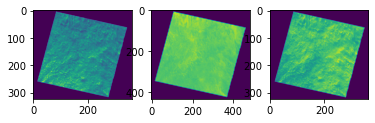

In [13]:
thumbnail_data = []

# url = azure_cog_urls[0]
for url in azure_cog_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the smallest thumbnail
        decimation_level = oviews[-1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w))
        thumbnail_data.append(thumbnail_channel)

fig, axes = plt.subplots(1, 3)

for i,d in enumerate(thumbnail_data):
    axes[i].imshow(d)

### Download support functions

In [16]:
max_path_len = 255

class DownloadProgressBar():
    """
    https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve
    """
    
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(max_value=total_size)
            self.pbar.start()
            
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    url_without_sas = url.split('?', 1)[0]
        
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        # url_as_filename = url.replace('://', '_').replace('/', '_').replace('?','_').replace('&',
        url_as_filename = re.sub(r'\W+', '', url_without_sas)
        n_folder_chars = len(temp_dir)
        if len(url_as_filename) + n_folder_chars > max_path_len:
            print('Warning: truncating filename target to {} characters'.format(max_path_len))
            url_as_filename = url_as_filename[-1*(max_path_len-n_folder_chars):]
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url_without_sas)))
        return destination_filename
    print('Downloading file {} to {}'.format(os.path.basename(url_without_sas),destination_filename),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### Download our HDF file

In [20]:
fn = download_url(url=azure_hdf_url,destination_filename=None,progress_updater=DownloadProgressBar())

Bypassing download of already-downloaded file AST_L1T_00301152004192004_20150502205642_77732.hdf


### Read all image bands from the HDF file

In [21]:
all_bands = {}

with rasterio.open(fn) as dataset:

    for name in dataset.subdatasets:
        
        if 'ImageData' not in name:
            continue
        
        # Open the band subdataset
        with rasterio.open(name) as subdataset:
                
            metadata = subdataset.profile
                
            # ImageData3N
            d = subdataset.read(1)
            
            # Names look like this:
            # HDF4_EOS:EOS_SWATH:C:/Users/dan/AppData/Local/Temp/aster/httpsastersablobcorewindowsnetasterimagesL1T20040115AST_L1T_00301152004192004_20150502205642_77732hdf:VNIR_Swath:ImageData3N
            
            # Just grab the channel name, e.g.:
            # ImageData3N
            all_bands[name.split(':')[-1]] = d

        # ...with rasterio.open()
    
    # ...for each subdataset
    
# ...with rasterio.open()

C:\users\dan\Anaconda3\lib\site-packages\rasterio\__init__.py:229: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### Plot one band

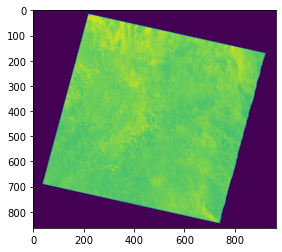

In [22]:
plt.imshow(all_bands['ImageData10'])

### Make an RGB composite

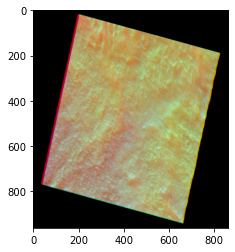

In [23]:
# An ASTER RGB composite recommendation I found in this paper, which has really pretty figures:
#
# Bakardjiev D, Popov K. ASTER spectral band ratios for detection of hydrothermal alterations and ore
# deposits in the Panagyurishte Ore Region, Central Srednogorie, Bulgaria. Review of the Bulgarian
# Geological Society. 2015 Jan 1;76(part 1):79-88.
#
rgb_bands = ['ImageData12','ImageData3N','ImageData5']

# First resample all three channels to the same size, since they may have
# come from different sensors.
x_sizes = [(all_bands[b].shape[0]) for b in rgb_bands]
min_x_index = x_sizes.index(min(x_sizes))

target_x_size = all_bands[rgb_bands[min_x_index]].shape[0]
target_y_size = all_bands[rgb_bands[min_x_index]].shape[1]

resized_band_values = []
for i_band,band_name in enumerate(rgb_bands):
    d = all_bands[band_name]
    resized_d = cv2.resize(d, dsize=(target_x_size, target_y_size), interpolation=cv2.INTER_CUBIC)
    # Normalize each band
    resized_d = resized_d / np.max(resized_d)
    resized_band_values.append(resized_d)

rgb = np.dstack((resized_band_values[0],resized_band_values[1],resized_band_values[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Clean up temporary files

In [24]:
shutil.rmtree(temp_dir)